In [3]:
import pytorch_lightning
from monai.utils import set_determinism
from monai.transforms import (
    AsDiscrete,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    ScaleIntensityRanged,
    Spacingd,
    EnsureType,
)
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, list_data_collate, decollate_batch, DataLoader
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob
import random
import nibabel as nib
import numpy as np
import SimpleITK as sitk
from math import floor, ceil

In [4]:
import sys
sys.path.append('../')
sys.path.insert(0, '../config/')
from config import Configuration
config = Configuration()
print(config.init['PROJECT_NAME'])
print(config.dataset['IMAGE_ROOT'])


FistulaSegmentation
/home/sasank/Dropbox (UFL)/FistulaData/Segmentations/


In [5]:
config.etl['DATA_DIR'] = '/home/sasank/Documents/GitRepos/Fistula-Segmentation/data/'

from net import SegmentationNet
net = SegmentationNet(config=config)

In [6]:
net.setup('fit')

/home/sasank/miniconda3/envs/fistula/lib/python3.10/site-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)
Loading dataset: 100%|██████████| 10/10 [00:04<00:00,  2.08it/s]


In [7]:
train_ds = net.train_ds
val_ds = net.val_ds
test_ds = net.test_ds

In [8]:
print("image size: ", train_ds[0]['image'].shape)
print("label size: ", train_ds[0]['label'].shape)
print(" image is of size " + str(train_ds[0]['image'].shape) + " and label is of size " + str(train_ds[0]['label'].shape))

image size:  torch.Size([1, 256, 128, 256])
label size:  torch.Size([1, 256, 128, 256])
 image is of size torch.Size([1, 256, 128, 256]) and label is of size torch.Size([1, 256, 128, 256])


In [9]:
output = net(train_ds[0]['image'].unsqueeze(0).cuda())

In [10]:
print("train_ds length", len(train_ds))
#print("train_ds[0]", train_ds[0])
#print("train_ds[0] shape", train_ds[0].shape)
print("train_ds[0] type", type(train_ds[0]))

print("val_ds length", len(val_ds))
print("val_ds[0] type", type(val_ds[0]))

print("test_ds length", len(test_ds))
print("test_ds[0] type", type(test_ds[0]))

train_ds length 32
train_ds[0] type <class 'dict'>


KeyError: 0

In [5]:
train_loader = net.train_dataloader()
test_loader = net.test_dataloader()

In [11]:
test_sample = test_loader.dataset[0]
#test_sample = test_loader.dataset[0]
print("train_loader:")
print("dataset batch size is " + str(train_loader.batch_size))
print("dataset length is " + str(len(train_loader.dataset)))
# What datatype is the dataset?
print("dataset type is " + str(type(train_loader.dataset)))
#print(test_sample.keys())
#print(train_loader.dataset.shape)
print("dataset[0] type is " + str(type(train_loader.dataset[0])))
print("dataset[0] length is " + str(len(train_loader.dataset[0])))
print("dataset[0] is " + str(train_loader.dataset[0]))
print("dataset[0][0] type is " + str(type(train_loader.dataset[0][0])))
print("dataset[0][0] length is " + str(len(train_loader.dataset[0][0])))
print("dataset[0][0] is " + str(train_loader.dataset[0][0]))
print("dataset[0][0]]['image'] type is " + str(type(train_loader.dataset[0][0]['image'])))
print("dataset[0][0]]['foreground_end_coord'] type is " + str(type(train_loader.dataset[0][0]['foreground_end_coord'])))



print("test_loader:")
print("dataset batch size is " + str(test_loader.batch_size))
print("dataset length is " + str(len(test_loader.dataset)))
# What datatype is the dataset?
print("dataset type is " + str(type(test_loader.dataset)))
#print(test_sample.keys())
#print(train_loader.dataset.shape)
print("dataset[0] type is " + str(type(test_loader.dataset[0])))
print("dataset[0] length is " + str(len(test_loader.dataset[0])))
print("dataset[0][0] type is " + str(type(test_loader.dataset[0][0])))
print("dataset[0][0]]['image'] type is " + str(type(test_loader.dataset[0][0]['image'])))
print("dataset[0][0]]['foreground_end_coord'] type is " + str(type(test_loader.dataset[0][0]['foreground_end_coord'])))

train_loader:
dataset batch size is 3
dataset length is 32
dataset type is <class 'monai.data.dataset.CacheDataset'>
dataset[0] type is <class 'list'>
dataset[0] length is 4
dataset[0] is [{'image': metatensor([[[[0.5928, 0.5430, 0.5701,  ..., 0.7511, 0.7783, 0.7330],
          [0.5701, 0.5385, 0.5566,  ..., 0.5113, 0.5928, 0.6425],
          [0.5701, 0.5385, 0.5566,  ..., 0.5113, 0.5928, 0.6425],
          ...,
          [0.7466, 0.6787, 0.6652,  ..., 0.3032, 0.2851, 0.2805],
          [0.7421, 0.6244, 0.6380,  ..., 0.3167, 0.2986, 0.2986],
          [0.7421, 0.6244, 0.6380,  ..., 0.3167, 0.2986, 0.2986]],

         [[0.5656, 0.5747, 0.5792,  ..., 0.6290, 0.6335, 0.6425],
          [0.5385, 0.5475, 0.5204,  ..., 0.4751, 0.4570, 0.5204],
          [0.5385, 0.5475, 0.5204,  ..., 0.4751, 0.4570, 0.5204],
          ...,
          [0.6742, 0.5792, 0.5837,  ..., 0.3213, 0.2760, 0.2941],
          [0.7692, 0.6516, 0.6471,  ..., 0.2986, 0.3077, 0.3032],
          [0.7692, 0.6516, 0.6471,  ...

KeyError: 0

In [ ]:

#print(test_loader.batch_size)
# print dimentions of test_loader.dataset
print(len(test_loader.dataset))
print(test_loader.batch_size)
print("dataset type is " + str(type(test_loader.dataset)))
print(type(test_loader.dataset[0]))
print(len(test_loader.dataset[0]))
print(type(test_loader.dataset[0][0]))
print(len(test_loader.dataset[0][0]))
# Okay, so the dataset is a list of batches, each containing a list of samples, each containing a dictionary of keys, which include the image, the label, and some coordinate metadata
# LOL, since the test set has batch size 1, it just squeezed out the batch dimension. Bruhhhhhh
#print(len(test_img))
print(test_sample.keys())
print(test_sample['foreground_end_coord'])

In [36]:
test_lbl = test_sample['label']
# Plot the number of non-zero pixels in each slice as a function of the first dimension
#plt.plot(np.sum(test_lbl, axis=(1,2)))
#plt.show()

shape of image: torch.Size([1, 240, 110, 200])
shape of label: torch.Size([1, 240, 110, 200])


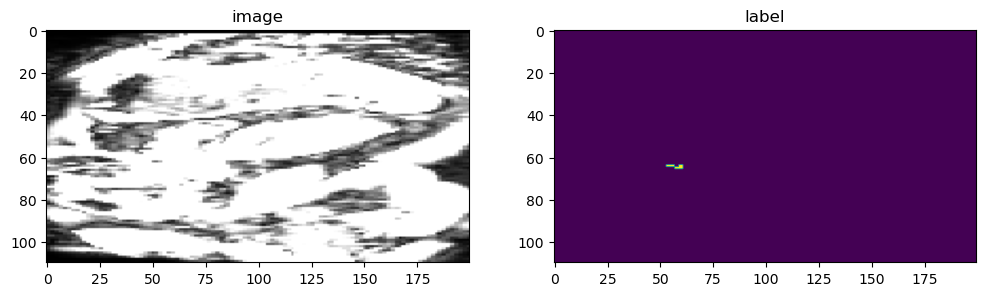

"\nfor i in range(4):\n    plt.subplot(1, 4, i + 1)\n    plt.imshow(test_img[i, :, :], cmap='gray')\n"

In [47]:
# print a slice from the first image of train_loader
SLICE = 158
test_img = test_sample['image']
print('shape of image:', test_img.shape)
test_lbl = test_sample['label']
print('shape of label:', test_lbl.shape)
plt.figure('check', (12, 6))
plt.subplot(1, 2, 1)
plt.title('image')
# show a slice of test_img on the first subplot
plt.imshow(test_img[0, SLICE, :, :], cmap='gray')
# show a slice of test_lbl on the second subplot
plt.subplot(1, 2, 2)
plt.title('label')
plt.imshow(test_lbl[0, SLICE, :, :])
plt.show()


"""
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.imshow(test_img[i, :, :], cmap='gray')
"""



In [45]:
# Check to see if test_lbl[0] has any non-zero values
print(np.sum(test_lbl[0]))
# Find the locations of the non-zero values
#print(np.nonzero(test_lbl[0]))
# Find the indices of the non-zero values
print(np.argwhere(test_lbl[0]))

310.0
[[158  64  53]
 [158  64  54]
 [158  64  55]
 [158  64  56]
 [158  64  59]
 [158  64  60]
 [158  65  57]
 [158  65  58]
 [158  65  59]
 [158  65  60]
 [159  63  55]
 [159  63  56]
 [159  63  57]
 [159  63  58]
 [159  63  59]
 [159  63  60]
 [159  64  53]
 [159  64  54]
 [159  64  55]
 [159  64  56]
 [159  64  57]
 [159  64  58]
 [159  64  59]
 [159  64  60]
 [159  65  53]
 [159  65  54]
 [159  65  55]
 [159  65  56]
 [159  65  57]
 [159  65  58]
 [159  65  59]
 [159  65  60]
 [159  65  61]
 [159  65  62]
 [159  66  59]
 [159  66  60]
 [160  63  53]
 [160  63  54]
 [160  63  55]
 [160  63  56]
 [160  63  57]
 [160  63  58]
 [160  63  59]
 [160  63  60]
 [160  64  53]
 [160  64  54]
 [160  64  55]
 [160  64  56]
 [160  64  57]
 [160  64  58]
 [160  64  59]
 [160  64  60]
 [160  64  61]
 [160  64  62]
 [160  65  53]
 [160  65  54]
 [160  65  55]
 [160  65  56]
 [160  65  57]
 [160  65  58]
 [160  65  59]
 [160  65  60]
 [160  65  61]
 [160  65  62]
 [160  66  59]
 [160  66  60]
 [16

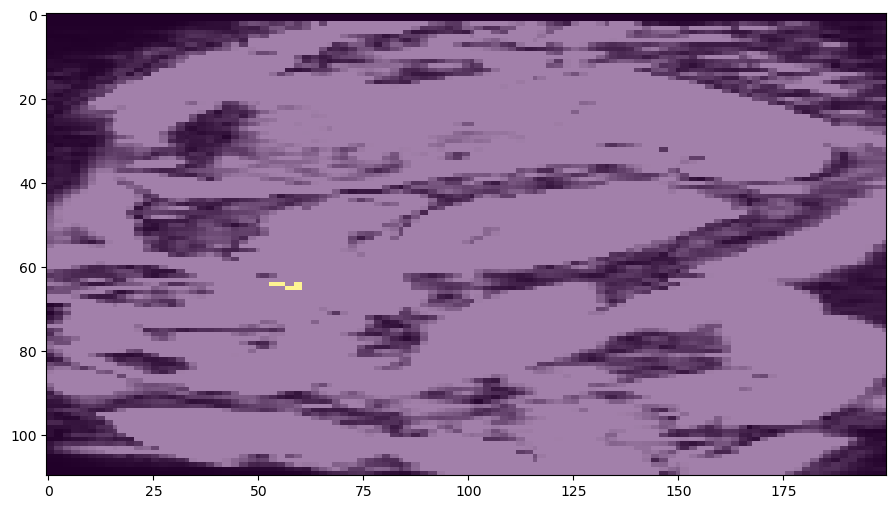

In [46]:
# Overlay the label on the image
SLICE=158
plt.figure('check', (12, 6))
plt.imshow(test_img[0, SLICE, :, :], cmap='gray')
plt.imshow(test_lbl[0, SLICE, :, :], alpha=0.5)
plt.show()